In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("📊 SPX Index Volatility Analysis")
print("=" * 50)

📊 SPX Index Volatility Analysis


In [5]:
# Load the historical volatility data - UPDATE THIS PATH TO YOUR ACTUAL DATA LOCATION
data_path = '../data/historical_volatility/historical_volatility_latest.csv'
df = pd.read_csv(data_path)

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Filter for SPX Index only
spx_data = df[df['ticker'] == 'SPX Index'].copy()

print(f"✅ Data loaded successfully")
print(f"   Total SPX observations: {len(spx_data):,}")
print(f"   Date range: {spx_data['date'].min().strftime('%Y-%m-%d')} to {spx_data['date'].max().strftime('%Y-%m-%d')}")
print(f"   Data types: {spx_data['data_type'].unique()}")

✅ Data loaded successfully
   Total SPX observations: 1,504
   Date range: 2022-07-20 to 2025-07-18
   Data types: ['realized' 'implied']


### 1. Data Overview and Quality Check

In [7]:
# Basic data info
print("🔍 SPX DATA OVERVIEW")
print("=" * 30)

# Split data by type
spx_realized = spx_data[spx_data['data_type'] == 'realized'].copy()
spx_implied = spx_data[spx_data['data_type'] == 'implied'].copy()

print(f"Realized volatility observations: {len(spx_realized):,}")
print(f"Implied volatility observations: {len(spx_implied):,}")

# Check data completeness
print(f"\n📈 REALIZED VOLATILITY DATA QUALITY")
realized_cols = ['realized_vol_30d', 'realized_vol_90d', 'realized_vol_180d', 'realized_vol_252d']
for col in realized_cols:
    if col in spx_realized.columns:
        non_null = spx_realized[col].notna().sum()
        total = len(spx_realized)
        pct = (non_null / total) * 100
        print(f"   {col}: {non_null:,}/{total:,} ({pct:.1f}%)")

print(f"\n📉 IMPLIED VOLATILITY DATA QUALITY")
implied_cols = ['implied_vol_1m_atm', 'implied_vol_3m_atm', 'implied_vol_6m_atm', 'implied_vol_12m_atm']
for col in implied_cols:
    if col in spx_implied.columns:
        non_null = spx_implied[col].notna().sum()
        total = len(spx_implied)
        pct = (non_null / total) * 100
        print(f"   {col}: {non_null:,}/{total:,} ({pct:.1f}%)")

🔍 SPX DATA OVERVIEW
Realized volatility observations: 752
Implied volatility observations: 752

📈 REALIZED VOLATILITY DATA QUALITY
   realized_vol_30d: 752/752 (100.0%)
   realized_vol_90d: 752/752 (100.0%)
   realized_vol_180d: 752/752 (100.0%)
   realized_vol_252d: 752/752 (100.0%)

📉 IMPLIED VOLATILITY DATA QUALITY
   implied_vol_1m_atm: 0/752 (0.0%)
   implied_vol_3m_atm: 752/752 (100.0%)
   implied_vol_6m_atm: 752/752 (100.0%)
   implied_vol_12m_atm: 752/752 (100.0%)


In [8]:
# Sample data preview
print("\n📊 SAMPLE DATA")
print("\nColumns available:")
print(f"SPX Realized columns: {spx_realized.columns.tolist()}")
print(f"SPX Implied columns: {spx_implied.columns.tolist()}")

if len(spx_realized) > 0:
    print("\nRealized Volatility Sample:")
    display_cols = ['date'] + [col for col in realized_cols if col in spx_realized.columns]
    print(spx_realized[display_cols].head().to_string(index=False))

if len(spx_implied) > 0:
    print("\nImplied Volatility Sample:")
    display_cols = ['date'] + [col for col in implied_cols if col in spx_implied.columns]
    print(spx_implied[display_cols].head().to_string(index=False))


📊 SAMPLE DATA

Columns available:
SPX Realized columns: ['date', 'ticker', 'data_type', 'realized_vol_30d', 'realized_vol_90d', 'realized_vol_180d', 'realized_vol_252d', 'implied_vol_1m_atm', 'implied_vol_3m_atm', 'implied_vol_6m_atm', 'implied_vol_12m_atm', 'implied_vol_1m_50delta', 'implied_vol_3m_50delta', 'implied_vol_6m_50delta', 'implied_vol_12m_50delta']
SPX Implied columns: ['date', 'ticker', 'data_type', 'realized_vol_30d', 'realized_vol_90d', 'realized_vol_180d', 'realized_vol_252d', 'implied_vol_1m_atm', 'implied_vol_3m_atm', 'implied_vol_6m_atm', 'implied_vol_12m_atm', 'implied_vol_1m_50delta', 'implied_vol_3m_50delta', 'implied_vol_6m_50delta', 'implied_vol_12m_50delta']

Realized Volatility Sample:
      date  realized_vol_30d  realized_vol_90d  realized_vol_180d  realized_vol_252d
2022-07-20             27.70             26.73              23.21              20.32
2022-07-21             27.75             26.77              23.24              20.34
2022-07-22            

### 2. Realized Volatility Time Series Analysis

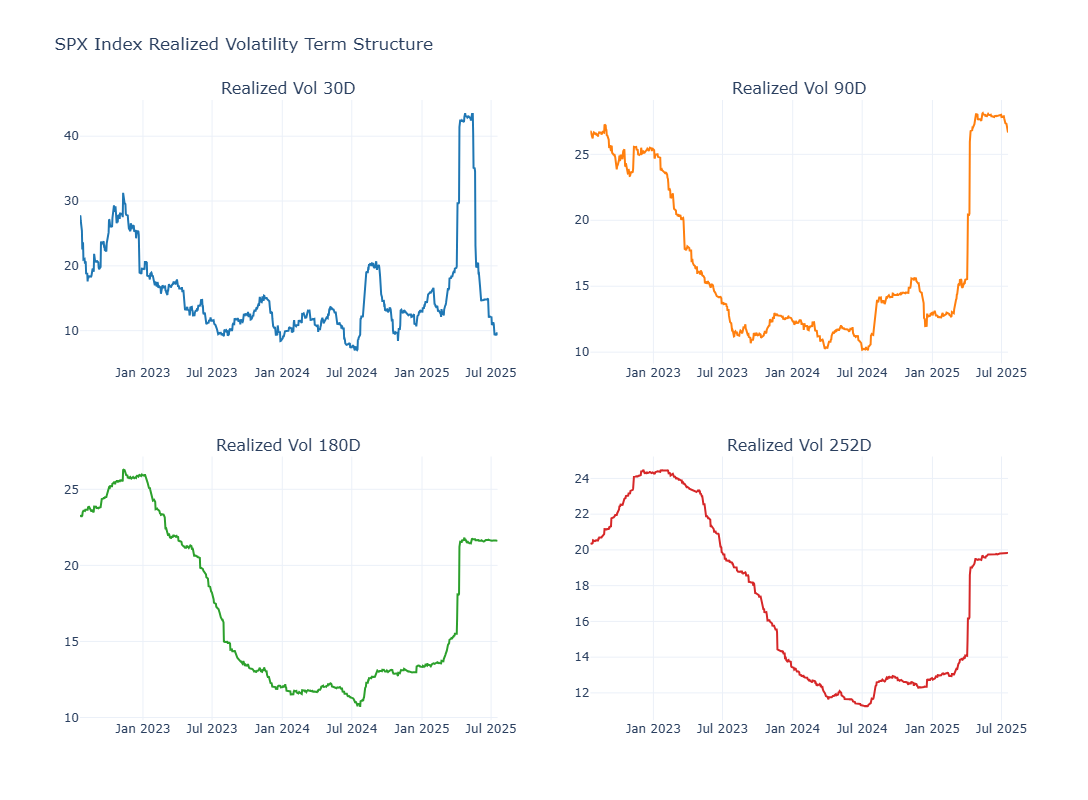

In [9]:
# Create comprehensive realized volatility chart
available_realized_cols = [col for col in realized_cols if col in spx_realized.columns]

if len(available_realized_cols) > 0:
    # Determine subplot layout based on available columns
    n_cols = len(available_realized_cols)
    if n_cols <= 2:
        rows, cols = 1, n_cols
    else:
        rows, cols = 2, 2
    
    fig = make_subplots(
        rows=rows, cols=cols,
        subplot_titles=[f'{col.replace("_", " ").title()}' for col in available_realized_cols[:4]],
        vertical_spacing=0.15
    )

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for i, col_name in enumerate(available_realized_cols[:4]):
        row = (i // cols) + 1
        col = (i % cols) + 1
        
        data_to_plot = spx_realized[spx_realized[col_name].notna()]
        
        fig.add_trace(
            go.Scatter(
                x=data_to_plot['date'],
                y=data_to_plot[col_name],
                mode='lines',
                name=col_name,
                line=dict(color=colors[i % len(colors)], width=2),
                hovertemplate=f'<b>{col_name}</b><br>' +
                             'Date: %{x}<br>' +
                             'Volatility: %{y:.2f}%<extra></extra>'
            ),
            row=row, col=col
        )

    fig.update_layout(
        title='SPX Index Realized Volatility Term Structure',
        height=600 if rows == 1 else 800,
        showlegend=False,
        template='plotly_white'
    )

    fig.show()
else:
    print("No realized volatility columns found in the data")

In [10]:
# Realized volatility summary statistics
if len(available_realized_cols) > 0:
    print("📊 REALIZED VOLATILITY SUMMARY STATISTICS")
    print("=" * 50)

    summary_stats = spx_realized[available_realized_cols].describe()
    print(summary_stats.round(2))

    # Correlation matrix
    if len(available_realized_cols) > 1:
        print(f"\n🔗 REALIZED VOLATILITY CORRELATIONS")
        correlations = spx_realized[available_realized_cols].corr()
        print(correlations.round(3))

📊 REALIZED VOLATILITY SUMMARY STATISTICS
       realized_vol_30d  realized_vol_90d  realized_vol_180d  \
count            752.00            752.00             752.00   
mean              16.09             16.97              17.08   
std                7.28              6.06               5.18   
min                6.97             10.14              10.70   
25%               11.62             11.98              12.66   
50%               13.44             14.32              14.26   
75%               18.78             23.79              21.70   
max               43.55             28.12              26.29   

       realized_vol_252d  
count             752.00  
mean               17.22  
std                 4.62  
min                11.22  
25%                12.71  
50%                17.38  
75%                21.24  
max                24.49  

🔗 REALIZED VOLATILITY CORRELATIONS
                   realized_vol_30d  realized_vol_90d  realized_vol_180d  \
realized_vol_30d           

### 3. Implied Volatility Time Series Analysis

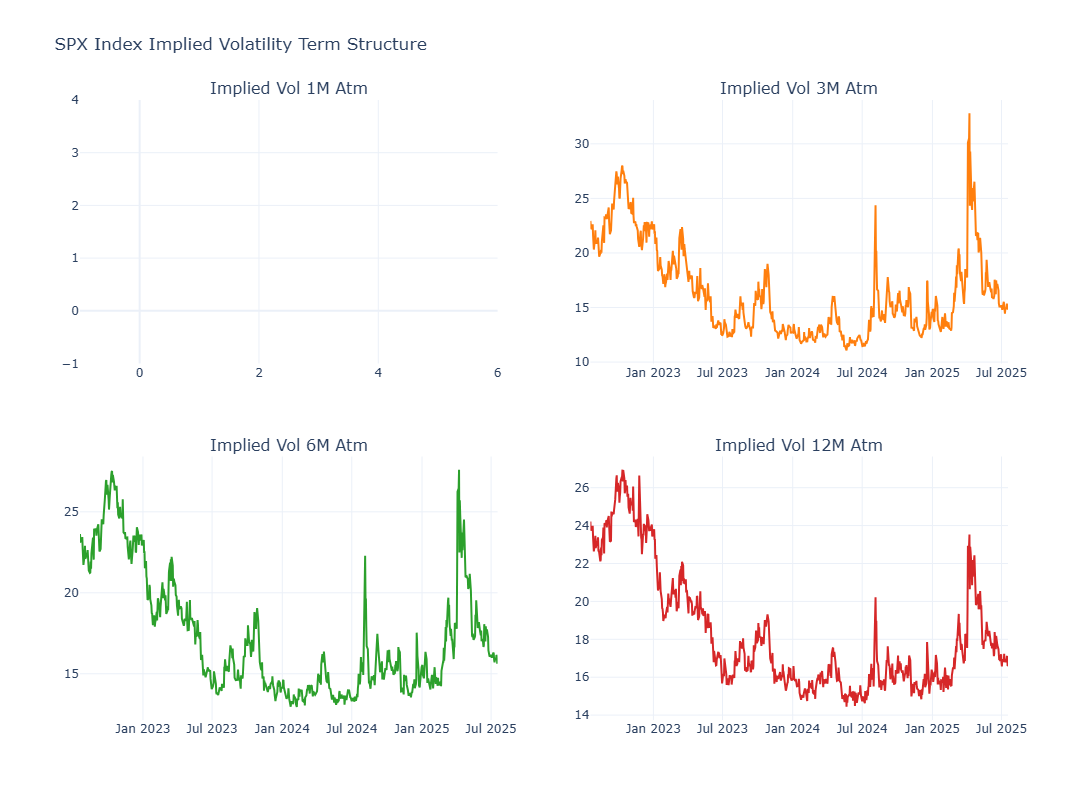

In [12]:
# Create implied volatility chart
available_implied_cols = [col for col in implied_cols if col in spx_implied.columns]

if len(available_implied_cols) > 0:
    # Determine subplot layout
    n_cols = len(available_implied_cols)
    if n_cols <= 2:
        rows, cols = 1, n_cols
    else:
        rows, cols = 2, 2
    
    fig = make_subplots(
        rows=rows, cols=cols,
        subplot_titles=[f'{col.replace("_", " ").title()}' for col in available_implied_cols[:4]],
        vertical_spacing=0.15
    )

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for i, col_name in enumerate(available_implied_cols[:4]):
        row = (i // cols) + 1
        col = (i % cols) + 1
        
        data_to_plot = spx_implied[spx_implied[col_name].notna()]
        
        fig.add_trace(
            go.Scatter(
                x=data_to_plot['date'],
                y=data_to_plot[col_name],
                mode='lines',
                name=col_name,
                line=dict(color=colors[i % len(colors)], width=2),
                hovertemplate=f'<b>{col_name}</b><br>' +
                             'Date: %{x}<br>' +
                             'Volatility: %{y:.2f}%<extra></extra>'
            ),
            row=row, col=col
        )

    fig.update_layout(
        title='SPX Index Implied Volatility Term Structure',
        height=600 if rows == 1 else 800,
        showlegend=False,
        template='plotly_white'
    )

    fig.show()
else:
    print("No implied volatility columns found in the data")

In [13]:
# Implied volatility summary statistics
if len(available_implied_cols) > 0:
    print("📊 IMPLIED VOLATILITY SUMMARY STATISTICS")
    print("=" * 50)

    summary_stats = spx_implied[available_implied_cols].describe()
    print(summary_stats.round(2))

    # Correlation matrix
    if len(available_implied_cols) > 1:
        print(f"\n🔗 IMPLIED VOLATILITY CORRELATIONS")
        correlations = spx_implied[available_implied_cols].corr()
        print(correlations.round(3))

📊 IMPLIED VOLATILITY SUMMARY STATISTICS
       implied_vol_1m_atm  implied_vol_3m_atm  implied_vol_6m_atm  \
count                 0.0              752.00              752.00   
mean                  NaN               16.44               17.31   
std                   NaN                4.14                3.70   
min                   NaN               11.08               12.96   
25%                   NaN               13.11               14.33   
50%                   NaN               15.20               15.98   
75%                   NaN               18.54               19.45   
max                   NaN               32.81               27.60   

       implied_vol_12m_atm  
count               752.00  
mean                 18.28  
std                   3.16  
min                  14.44  
25%                  15.89  
50%                  16.98  
75%                  19.92  
max                  26.95  

🔗 IMPLIED VOLATILITY CORRELATIONS
                     implied_vol_1m_atm  i

### 4. Realized vs Implied Volatility Comparison

In [14]:
# Find best matching columns for comparison
realized_comparison_col = None
implied_comparison_col = None

# Look for 90-day realized and 3-month implied
if 'realized_vol_90d' in spx_realized.columns:
    realized_comparison_col = 'realized_vol_90d'
elif 'realized_vol_30d' in spx_realized.columns:
    realized_comparison_col = 'realized_vol_30d'

if 'implied_vol_3m_atm' in spx_implied.columns:
    implied_comparison_col = 'implied_vol_3m_atm'
elif 'implied_vol_1m_atm' in spx_implied.columns:
    implied_comparison_col = 'implied_vol_1m_atm'

if realized_comparison_col and implied_comparison_col:
    # Merge realized and implied data for comparison
    spx_realized_clean = spx_realized[['date', realized_comparison_col]].dropna()
    spx_implied_clean = spx_implied[['date', implied_comparison_col]].dropna()

    # Merge on date
    comparison_data = pd.merge(spx_realized_clean, spx_implied_clean, on='date', how='inner')

    print(f"📈 REALIZED vs IMPLIED COMPARISON")
    print(f"   Comparing: {realized_comparison_col} vs {implied_comparison_col}")
    print(f"   Overlapping observations: {len(comparison_data):,}")
    if len(comparison_data) > 0:
        print(f"   Date range: {comparison_data['date'].min().strftime('%Y-%m-%d')} to {comparison_data['date'].max().strftime('%Y-%m-%d')}")
else:
    print("Cannot find matching realized and implied volatility columns for comparison")
    comparison_data = pd.DataFrame()

📈 REALIZED vs IMPLIED COMPARISON
   Comparing: realized_vol_90d vs implied_vol_3m_atm
   Overlapping observations: 752
   Date range: 2022-07-20 to 2025-07-18


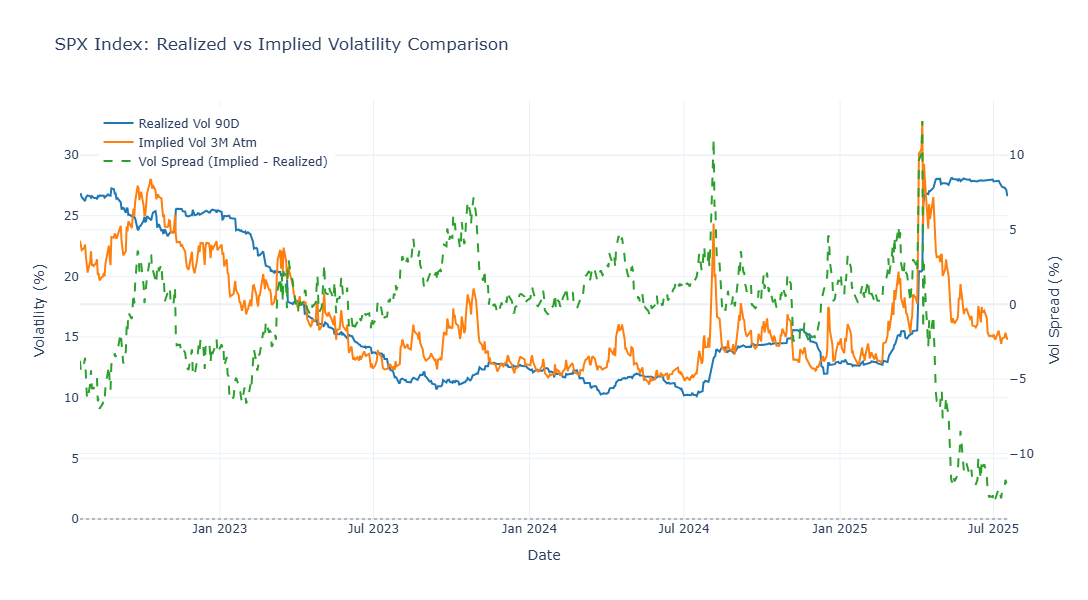

In [15]:
# Create realized vs implied comparison chart
if len(comparison_data) > 0:
    fig = go.Figure()

    # Add realized volatility
    fig.add_trace(
        go.Scatter(
            x=comparison_data['date'],
            y=comparison_data[realized_comparison_col],
            mode='lines',
            name=f'{realized_comparison_col.replace("_", " ").title()}',
            line=dict(color='#1f77b4', width=2),
            hovertemplate=f'<b>{realized_comparison_col}</b><br>' +
                         'Date: %{x}<br>' +
                         'Volatility: %{y:.2f}%<extra></extra>'
        )
    )

    # Add implied volatility
    fig.add_trace(
        go.Scatter(
            x=comparison_data['date'],
            y=comparison_data[implied_comparison_col],
            mode='lines',
            name=f'{implied_comparison_col.replace("_", " ").title()}',
            line=dict(color='#ff7f0e', width=2),
            hovertemplate=f'<b>{implied_comparison_col}</b><br>' +
                         'Date: %{x}<br>' +
                         'Volatility: %{y:.2f}%<extra></extra>'
        )
    )

    # Add volatility spread
    vol_spread = comparison_data[implied_comparison_col] - comparison_data[realized_comparison_col]
    fig.add_trace(
        go.Scatter(
            x=comparison_data['date'],
            y=vol_spread,
            mode='lines',
            name='Vol Spread (Implied - Realized)',
            line=dict(color='#2ca02c', width=2, dash='dash'),
            yaxis='y2',
            hovertemplate='<b>Vol Spread</b><br>' +
                         'Date: %{x}<br>' +
                         'Spread: %{y:.2f}%<extra></extra>'
        )
    )

    # Add zero line for spread
    fig.add_hline(y=0, line_dash="dot", line_color="gray", opacity=0.5)

    fig.update_layout(
        title='SPX Index: Realized vs Implied Volatility Comparison',
        xaxis_title='Date',
        yaxis_title='Volatility (%)',
        yaxis2=dict(
            title='Vol Spread (%)',
            overlaying='y',
            side='right'
        ),
        height=600,
        template='plotly_white',
        legend=dict(x=0.02, y=0.98)
    )

    fig.show()

### 5. Volatility Regime Analysis

In [16]:
# Define volatility regimes based on available realized vol data
vol_col_for_regime = None

if 'realized_vol_30d' in spx_realized.columns:
    vol_col_for_regime = 'realized_vol_30d'
elif 'realized_vol_90d' in spx_realized.columns:
    vol_col_for_regime = 'realized_vol_90d'

if vol_col_for_regime:
    def categorize_vol_regime(vol):
        if pd.isna(vol):
            return 'Unknown'
        elif vol < 15:
            return 'Low Vol'
        elif vol < 25:
            return 'Normal Vol'
        elif vol < 35:
            return 'Elevated Vol'
        else:
            return 'High Vol'

    # Add regime classification
    spx_realized['vol_regime'] = spx_realized[vol_col_for_regime].apply(categorize_vol_regime)

    # Regime summary
    regime_summary = spx_realized['vol_regime'].value_counts()
    print("📊 VOLATILITY REGIME BREAKDOWN")
    print(f"Based on: {vol_col_for_regime}")
    print("=" * 40)
    for regime, count in regime_summary.items():
        pct = (count / len(spx_realized)) * 100
        print(f"{regime}: {count:,} days ({pct:.1f}%)")
else:
    print("No suitable volatility column found for regime analysis")

📊 VOLATILITY REGIME BREAKDOWN
Based on: realized_vol_30d
Low Vol: 450 days (59.8%)
Normal Vol: 211 days (28.1%)
Elevated Vol: 63 days (8.4%)
High Vol: 28 days (3.7%)


### 6. Key Insights and Summary

In [17]:
# Calculate key metrics for summary
if vol_col_for_regime and len(spx_realized) > 0:
    latest_date = spx_realized['date'].max()
    latest_data = spx_realized[spx_realized['date'] == latest_date]
    
    if len(latest_data) > 0:
        latest_vol = latest_data[vol_col_for_regime].iloc[0]
        latest_regime = latest_data['vol_regime'].iloc[0] if 'vol_regime' in latest_data.columns else 'Unknown'

        # Historical percentiles
        vol_clean = spx_realized[vol_col_for_regime].dropna()
        current_percentile = (vol_clean < latest_vol).mean() * 100 if not pd.isna(latest_vol) else 0

        print("🎯 KEY INSIGHTS & SUMMARY")
        print("=" * 50)
        print(f"📅 Analysis Period: {spx_data['date'].min().strftime('%B %Y')} to {spx_data['date'].max().strftime('%B %Y')}")
        print(f"📊 Total Trading Days: {len(spx_realized):,}")
        print(f"\n🔍 CURRENT VOLATILITY STATUS")
        print(f"   Latest {vol_col_for_regime}: {latest_vol:.2f}%")
        print(f"   Current regime: {latest_regime}")
        print(f"   Historical percentile: {current_percentile:.1f}%")

        print(f"\n📈 HISTORICAL VOLATILITY RANGES")
        print(f"   {vol_col_for_regime} range: {vol_clean.min():.1f}% - {vol_clean.max():.1f}%")
        print(f"   Average: {vol_clean.mean():.1f}%")
        print(f"   Median: {vol_clean.median():.1f}%")

        if 'vol_regime' in spx_realized.columns:
            print(f"\n⚡ VOLATILITY REGIME PERIODS")
            for regime, count in regime_summary.items():
                if regime != 'Unknown':
                    pct = (count / len(spx_realized)) * 100
                    print(f"   {regime}: {pct:.1f}% of time")

        if len(comparison_data) > 0:
            comparison_data['vol_spread'] = comparison_data[implied_comparison_col] - comparison_data[realized_comparison_col]
            implied_premium_pct = (comparison_data['vol_spread'] > 0).mean() * 100
            print(f"\n🎯 IMPLIED vs REALIZED")
            print(f"   Average vol spread: {comparison_data['vol_spread'].mean():.2f}%")
            print(f"   Implied premium {implied_premium_pct:.1f}% of time")

        print(f"\n📊 DATA QUALITY")
        realized_completeness = (spx_realized[vol_col_for_regime].notna().sum() / len(spx_realized) * 100)
        print(f"   Realized vol completeness: {realized_completeness:.1f}%")
        
        if len(spx_implied) > 0 and implied_comparison_col:
            implied_completeness = (spx_implied[implied_comparison_col].notna().sum() / len(spx_implied) * 100)
            print(f"   Implied vol completeness: {implied_completeness:.1f}%")
    else:
        print("No data available for the latest date")
else:
    print("Insufficient data for summary analysis")

🎯 KEY INSIGHTS & SUMMARY
📅 Analysis Period: July 2022 to July 2025
📊 Total Trading Days: 752

🔍 CURRENT VOLATILITY STATUS
   Latest realized_vol_30d: 9.29%
   Current regime: Low Vol
   Historical percentile: 5.1%

📈 HISTORICAL VOLATILITY RANGES
   realized_vol_30d range: 7.0% - 43.5%
   Average: 16.1%
   Median: 13.4%

⚡ VOLATILITY REGIME PERIODS
   Low Vol: 59.8% of time
   Normal Vol: 28.1% of time
   Elevated Vol: 8.4% of time
   High Vol: 3.7% of time

🎯 IMPLIED vs REALIZED
   Average vol spread: -0.52%
   Implied premium 58.5% of time

📊 DATA QUALITY
   Realized vol completeness: 100.0%
   Implied vol completeness: 100.0%


In [18]:
# Cell X: Load the lagged analysis functions
# (Copy the code from the artifact above)

# Cell X+1: Run the lagged analysis  
print("🔄 Running Properly Lagged Volatility Analysis...")
lagged_comparisons = run_lagged_analysis(df)

🔄 Running Properly Lagged Volatility Analysis...


NameError: name 'run_lagged_analysis' is not defined